# Initial learning trials
functional: b3lypg

basis: sto-3g

In [12]:
import numpy as np
from glob import glob
import os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

train_test_seed = 42

source_path = '../../datasets/QM9/xyz_c5h4n2o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

509

In [6]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap

check if all files converged - if we have something to compare to!

In [42]:
focks = []
used_files = []
for file in all_file_paths:
    mol_name = os.path.basename(file).split(".")[0]
    # print(mol_name)
    ret = density_fock_overlap(filepath = file,
                         filename = mol_name,
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")
    if any([r == None for r in ret]): 
        print(f"File {mol_name} bad - skipping")
        continue
    focks.append(ret[1].numpy)
    used_files.append(file)
print(f"Using {len(focks)} files from {len(all_file_paths)} total files")

File dsgdb9nsd_057125 bad - skipping
Using 508 files from 509 total files


Now let's create the reference - use the overlap matrix - this is already needed for the first step so this is basically free! 

In [ ]:
from scf_guess_tools import Backend, load
from pyscf.gto import Mole
import re, time
import matplotlib.pyplot as plt

overlaps = []
for file in used_files:
    lines = open(file).readlines()
    q = int(re.search(r"charge\s+(-?\d+)", lines[1]).group(1))
    m = int(re.search(r"multiplicity\s+(\d+)", lines[1]).group(1))
    start_ = time.time()
    mol = Mole(atom=file, charge=q, spin=m - 1, symmetry=True)
    mol.basis = 'sto-3g'
    mol.build()
    S = mol.intor('int1e_ovlp')
    overlaps.append(np.asarray(S))

(49, 49)

Now we have our in & outputs but half of the matrix is irrelevant so we use the following utility functions

In [40]:
def flatten_triang(M): 
    return M[np.triu_indices(M.shape[0], k=0)]
def unflatten_triang(flat, N):
    M = np.zeros((N, N))
    iu = np.triu_indices(N)
    M[iu] = flat
    M[(iu[1], iu[0])] = flat  # Symmetrie
    return M

## Dataset split

In [43]:
train, test = train_test_split(
    list(zip(focks, overlaps)), 
    test_size=0.2, 
    random_state=train_test_seed
)

### Now Ridge Regression

In [63]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor

In [67]:
X = np.array([flatten_triang(overlap) for _, overlap in train])
y = np.array([flatten_triang(fock) for fock, _ in train])
base_model = RidgeCV(alphas=np.logspace(-1.5, 2.5, 5, base=10), cv=5)
model = MultiOutputRegressor(base_model)
start_ = time.time()
model.fit(X,y=y)
print(f"CV Training time: {time.time() - start_:.2f} seconds")
best_alphas = np.array([estimator.alpha_ for estimator in model.estimators_])
print(f"Best alphas: \nmean: {best_alphas.mean()}\nstd: {best_alphas.std()}\nmin: {best_alphas.min()}\nmax: {best_alphas.max()}")
base_model = Ridge(alpha=best_alphas.mean())
model = MultiOutputRegressor(base_model)

start_ = time.time()
model.fit(X, y=y)
print(f"Refit-Training time: {time.time() - start_:.2f} seconds")
# train error: 
train_pred = model.predict(X)
train_error = root_mean_squared_error(y, train_pred)
print(f"Train error: {train_error:.4f}")

# test error:
X_test = np.array([flatten_triang(overlap) for _, overlap in test])
y_test = np.array([flatten_triang(fock) for fock, _ in test])
test_pred = model.predict(X_test)
test_error = root_mean_squared_error(y_test, test_pred)
print(f"Test error: {test_error:.4f}")
sum_of_squares = np.mean(np.sum((np.zeros_like(y_test) - y_test)**2, axis=1))
print(f"Average sum of squares of y_test: {sum_of_squares:.4f}")

CV Training time: 139.88 seconds
Best alphas: 
mean: 5.663781269174882
std: 38.239596324243095
min: 0.03162277660168379
max: 316.22776601683796
Refit-Training time: 5.69 seconds
Train error: 0.0436
Test error: 0.0570
Average sum of squares of y_test: 1801.2192


ok sum of squares is really large compared to RMSE and RMSE between train and test is comparable but certainly not good -> I mean we have a small dataset only 508 samples!

RMSE: 0.1052


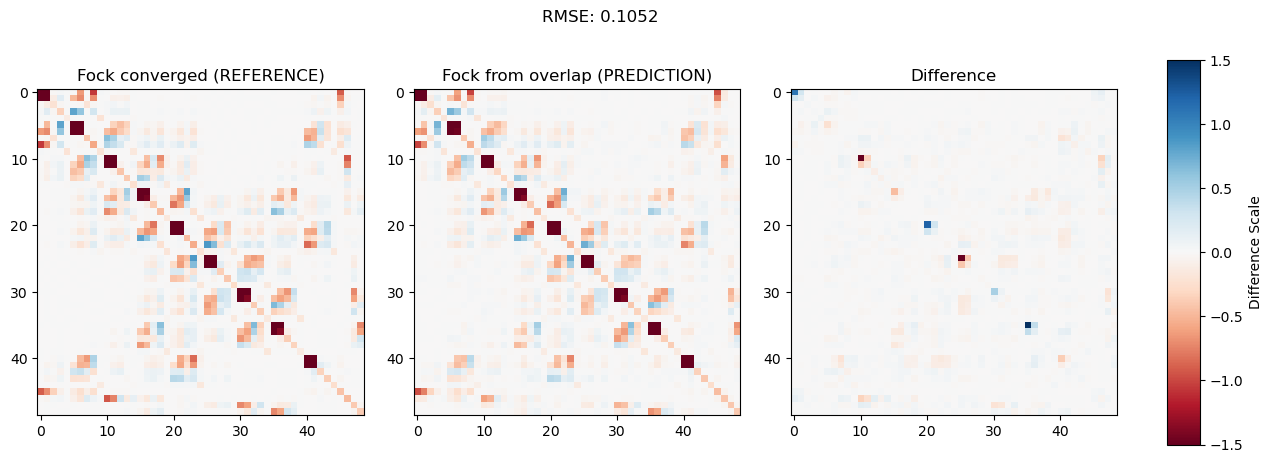

In [100]:
# let's checkout a example: 
random_test_sample = np.random.randint(0, len(X_test))
ex_test = y_test[random_test_sample]
ex_pred = test_pred[random_test_sample]

diff = ex_test - ex_pred
diff = unflatten_triang(diff, 49)
rmse = root_mean_squared_error(ex_test, ex_pred)
print(f"RMSE: {rmse:.4f}")
fig, ax = plt.subplots(1, 4, figsize=(15, 5), width_ratios=[1, 1, 1, 0.1])
fig.suptitle(f"RMSE: {rmse:.4f}")
ax[0].imshow(unflatten_triang(ex_test, 49), cmap='RdBu', vmin=-1.5, vmax=1.5)
ax[0].set_title("Fock converged (REFERENCE)")
ax[1].imshow(unflatten_triang(ex_pred, 49), cmap='RdBu', vmin=-1.5, vmax=1.5)
ax[1].set_title("Fock from overlap (PREDICTION)")
diff_plot = ax[2].imshow(diff, cmap='RdBu', vmin=-1.5, vmax=1.5)
ax[2].set_title("Difference")
cbar = fig.colorbar(diff_plot, cax=ax[3])
cbar.set_label("Difference Scale")